# 7 - Neural Ordinary Differential Equations para la predicción de una serie temporal

* Construimos una Neural ODE con el objetivo de predecir señales de Hahn a partir de una cantidad reducida de datos. Como las señales de Hahn se cruzan entre sí tanto en el mismo punto inicial como en diferentes puntos, utilizamos un embedding para representar las señales de Hahn en un espacio de características de mayor dimensión. Este embedding está compuesto por la señal de Hahn original y la derivada de la señal de Hahn. Luego, utilizamos una Neural ODE para predecir la señal de Hahn en el futuro.

* Para tener un conjunto de señales sencillos para entrenar y chequear que funciona, utilizo señales de Hahn simuladas con un mismo $\sigma = 1$ y ver si la red puede predecir 50 señales de estas. Para un proceso mas complejo se buscaria entrenar con multiples señales de Hahn con diferentes $\sigma$.

* De manera mas general seleccionamos un subconjunto reducido de señales que sea representativo aproximadamente de todas las señales que tenemos simuladas en el dataset. El cual nos daría una red que cumpliría con las predicciones de los datos de manera general.

### Importamos las librerias necesarias

In [40]:
using Flux
using Flux: train!
using DataFrames
using CSV
using DifferentialEquations
using SciMLSensitivity
using ComponentArrays, Optimization, OptimizationOptimJL, OptimizationFlux
using Interpolations
using OrdinaryDiffEq
using IterTools: ncycle

### Cargamos los parámetros fijos

In [41]:
# Parámetros fijos
N = 5000
time_sample_lenght_long = 1000
time_sample_lenght_short = 100

# Rango de tamaños de compartimientos en μm
l0 = 0.01
lf = 45

# Tiempo final de simulación en s
tf = 1

# Ahora generamos los datos para eso necesitamos hacer el sampling de los lc y los t
lc = range(l0, lf, length = N) # Esto nos da un muestreo de 0,008998 μm en lc
t_short = collect(range(0, 0.1, length = time_sample_lenght_short)) # Muestreo corto de 0.1 ms
t_long = collect(range(0.1, 1, length = time_sample_lenght_long)) # Muestreo largo de 10 ms

# Concatenamos los tiempos para tener un muestreo completo 
t = vcat(t_short, t_long)

# Parametros que se varian, estos se corresponden a la mediana y la desviación estándar de la distribución de tamaños de compartimientos lcms en μm y σs adimensionales

lcms = 0.5:0.01:6
σs = 0.01:0.01:1;

### Utilidades para cargar las señales a partir de un rango de índices

In [42]:
# Función para leer las señales
function GetSignals(path_read)
    dataSignals = CSV.read(path_read * "/dataSignals.csv", DataFrame)
    dataSignals = Matrix(dataSignals)
    return dataSignals
end

# Funcion que tomas algunas señales para utilizarlas en el entrenamiento de la NODE, recibe el numero de señales que quermos tomar y de donde las queremos tomar
function Get_Signals_Test(rango, path_read, muestreo_corto, muestreo_largo)
    # Leemos las señales desde el archivo
    dataSignals = Float32.(GetSignals(path_read))
    # Tomamos únicamente el rango de señales que vamos a tomar para esta red
    Signals_test = Float32.(Matrix(dataSignals[:,rango]'))
    # Tomamos un subconjunto de tiempos para agilizar el entrenamiento, tiempos cortos es decir el muestreo hasta 0.1 s
    Signals_test_short = Signals_test[:,1:muestreo_corto:1000]
    # Tiempos largos es decir el muestreo después de 0.1 s
    Signals_test_long = Signals_test[:,1001:muestreo_largo:end]
    # Concatenamos las señales con el nuevo muestreo para agilizar el entrenamiento
    Signals_test = hcat(Signals_test_short, Signals_test_long)
    return Signals_test
end

###################################################################################
# Función que idientifca las señales utilizadas, es decir los parámetros lcm y σ
function Get_Signals_Test_Parameters(numSignals,lcms,σs)
    dim1 = dimlcm = length(lcms)
    dim2 = dimσ = length(σs)

    # Inicializamos los arreglos que vamos a utilizar
    column_lcm = zeros(dim1*dim2)
    column_σs = zeros(dim1*dim2)
    # Convertimos los iterables de lcm y sigma con los cuales generamos las señales en arreglos
    aux_lcm = collect(lcms)
    aux_σs = collect(σs)

    # Asignamos los valores de lcm y sigma ordenados tal cual están las señales, es decir los datos comienzan en σ = 0.1 y lcm = 0.5 y va en aumento de lcm hasta 6 y luego pasa al siguiente σ
    for i in 1:dim1
        for j in 1:dim2
            column_lcm[(i - 1)*dim2 + j] = aux_lcm[i]
            column_σs[(i - 1)*dim2 + j] = aux_σs[j]
        end
    end
    # Con esto ya tenemos los arrelgos de los parámetros que se utilizaron para generar las señales
    column_lcm_test = column_lcm[1:Int(length(column_lcm)/numSignals):end]
    column_σs_test = column_σs[1:Int(length(column_σs)/numSignals):end]
    
    return column_lcm_test, column_σs_test
end

# Función que devuelve señales de prueba, sus derivadas y los parámetros con los que se generaron
function Get_Signals_Data_Training(path_read, rango, lcms, sigmas, muestreo_corto, muestreo_largo)
    # Obtenemos las señales que vamos a utilizar
    Signals_test = Get_Signals_Test(rango, path_read, muestreo_corto, muestreo_largo)
    # Obtenemos los parámetros con los que se generaron las señales
    column_lcm_test, column_sigmass_test = Get_Signals_Test_Parameters(rango,lcms,sigmas)
    # Calculamos las derivadas de las señales
    Signals_test_derivadas = zeros(size(Signals_test))
    for i in 1:size(Signals_test)[1]
        Signals_test_derivadas[i,:] = derivate_signals(t,Signals_test[i,:])
    end
    Signals_test_derivadas = Float32.(Matrix(Signals_test_derivadas'))
    # Normalizamos las derivadas
    for i in 1:size(Signals_test)[1]
        Signals_test_derivadas[:,i] = Signals_test_derivadas[:,i] ./ maximum(abs.(Signals_test_derivadas[:,i]))
    end
    return Signals_test, Signals_test_derivadas, column_lcm_test, column_sigmass_test
end;

### Función para las derivadas

In [43]:
# Vamos a hacer una función que nos permita calcular las derivadas de las señales
# Para esto vamos a usar diferencias finitas centradas
# La función recibe como argumentos el arreglo de señales y el arreglo de tiempos
# La función regresa un arreglo de derivadas de las señales

function derivate_signals(t,signal)
    # Calcula el tamaño de la ventana
    w = 1
    # Calcula el tamaño de la señal
    n = length(signal)
    # Inicializa el arreglo de derivadas
    derivadas = zeros(n)
    for i in 1:n
        # Encuentra los índices de la ventana
        inicio = max(1, i-w)
        final = min(n, i+w)
        # Utiliza diferencias finitas centradas si es posible
        if inicio != i && final != i
            derivadas[i] = (signal[final] - signal[inicio]) / (t[final] - t[inicio])
        elseif inicio == i
            # Diferencia hacia adelante si estamos en el comienzo del arreglo
            derivadas[i] = (signal[i+1] - signal[i]) / (t[i+1] - t[i])
        else
            # Diferencia hacia atrás si estamos al final del arreglo
            derivadas[i] = (signal[i] - signal[i-1]) / (t[i] - t[i-1])
        end
    end
    return derivadas
end;

### Entrenamiento de las NODE

In [44]:
# Función que crea el modelo de la red neuronal que va a estar dentro de la ODE
function create_model(layers::Vector{Int}, activation)
    """Función que crea el modelo de la red neuronal que va a estar dentro de la ODE

    Parameters:
        layers::Vector{Int} : Vector con las capas de la red neuronal
        activation : Función de activación de la red neuronal para todas las capas

    Returns:
        function Chain : Red neuronal creada
    """
    # Creamos la red neuronal con las capas y la activación que nos pasan
    activations = [activation for i in 1:length(layers) - 2]
    # Regresamos la red neuronal
    return Chain([Dense(layers[i], layers[i+1], activations[i]) for i in 1:length(layers) - 2]..., Dense(layers[end-1], layers[end]))
end

###################################################################################

# Función que entrena la NODE con mini-batchs
function Train_Neural_ODE(nn, U0, extra_parameters ,num_epochs, train_loader, opt, eta, Signals, Signals_forecast, t, tforecast)
    """Función que entrena la NODE con mini-batchs
    Parameters:
        nn : Red neuronal que va a estar dentro de la ODE
        U0 : Condiciones iniciales de la ODE
        extra_parameters : Parámetros extra que se le pasan a la red neuronal
        num_epochs : Número de epochs que se va a entrenar la red
        train_loader : DataLoader con los datos de entrenamiento
        opt : Optimizador que se va a utilizar
        eta : Learning rate
        Signals : datos de las señales que se van a utilizar para entrenar la red
        Signals_forecast : datos de las señales que se buscan predecir
        t : Tiempos de las señales recortado que se usa para entrenar la red
        tforecast : Tiempos de las señales que se van a predecir
    Returns:
        loss : Arreglo con el loss de la red neuronal
        p : Parámetros de la red neuronal
        loss_forecast : Arreglo con el loss de la red neuronal para los datos de las señales que se predicen
    """
    # Tiempo sobre el cual resolver
    tspan = (0f0, 1f0)

    # Parametrizar indices para poder acceder a los parametros extras de la red neuronal durante el entrenamiento y predicción
    f(x,p) = round(Int, x * (length(p) - 1)) + 1

    # Para entrenar la red tenemos que extraer los parametros de la red neuronal en su condicion inicial
    p, re = Flux.destructure(nn) 

    # Optimizardor que se va a utilizar
    opt = opt(eta)

    # Función que resuelve la ODE con los parametros extra y las condiciones iniciales que instanciemos y nos regresa la solución en un arreglo
    function predict_NeuralODE(u0, parametros, time_batch)
        # dSdt = NN(S, parametros_extra) 
        function dSdt(u, p, t; parametros_extra = parametros)
            # Selecciona el indice de los parametros extra en el tiempo t
            indx = f(t, parametros)
            # Selecciona los parametros extra en el tiempo t
            parametros_actuales = parametros[indx]
            # Concatena los el valor de S(t) con los parametros extra en el tiempo t
            entrada_red = vcat(u, parametros_actuales)
            # Regresa la salida de la red neuronal reconstruida con los parámetros p y esta vez con los parametros extra en el tiempo t
            return re(p)(entrada_red) 
        end

        # Definimos el problema de la ODE
        prob = ODEProblem(dSdt, u0, tspan)

        # Resolvemos la ODE y la devolvemos
        return Array(solve(prob, Tsit5(), dtmin=1e-9 , u0 = u0, p = p, saveat = time_batch, reltol = 1e-7, abstol = 1e-7))
    end

    # Función que predice las señales para un conjunto de condiciones iniciales
    function Predict_Singals(U0, parametros_extra, time_batch)
        Predicted_Signals = zeros(size(time_batch))
        # Iteramos sobre las condiciones iniciales y las derivadas de las señales
        for i in 1:length(U0)
            u0 = Float32[U0[i]]
            predicted_signal = predict_NeuralODE(u0, parametros_extra[:, i], time_batch)[1, :]
            Predicted_Signals = hcat(Predicted_Signals, predicted_signal)
        end
        Predicted_Signals[:,2:end]
    end

    # Función de loss que vamos a minimizar, recibe un batch de señales y un batch de tiempos
    function loss_node(batch, time_batch)
        y = Predict_Singals(U0, extra_parameters, time_batch)
        return Flux.mse(y, batch')
    end
    
    # Función de callback para guardar el loss cada epoch
    global iter = 0
    loss = []
    loss_forecast = []
    callback = function ()
        global iter += 1
        if iter % (length(train_loader)) == 0
            epoch = Int(iter / length(train_loader))
            actual_loss = loss_node(Signals, t)
            forecast_loss = loss_node(Signals_forecast, tforecast)
            # println("Epoch = $epoch || Loss: $actual_loss || Loss Forecast: $forecast_loss")
            push!(loss, actual_loss)
            push!(loss_forecast, forecast_loss)
        end
        return false
    end

    # Entrenamos la red neuronal con mini-batchs
    Flux.train!(loss_node, Flux.params(p), ncycle(train_loader, num_epochs), opt, cb = callback)
    
    # Devolvemos el loss final y los parametros de la red neuronal
    return loss, p, loss_forecast

end;

### Función main donde se exploran distintas redes

In [45]:
function main()
    # Arquitecturas que vamos a utilizar
    architectures = [
        [[2, 8, 1], relu], # Una capa oculta
        [[2, 8, 1], tanh], # Misma con activación tanh
        [[2, 8, 1], swish], # Misma con activación swish
        
        [[2, 16, 16, 1], relu], # Dos capas ocultas
        [[2, 16, 16, 1], tanh], # Misma con activación tanh
        [[2, 16, 16, 1], swish], # Misma con activación swish
        
        [[2, 32, 64, 16, 1], relu], # Tres capas ocultas
        [[2, 32, 64, 16, 1], tanh], # Misma con activación tanh
        [[2, 32, 64, 16, 1], swish], # Misma con activación swish

        [[2, 50, 64, 16, 1], relu], # Tres capas ocultas con mas neuronas
        [[2, 50, 64, 16, 1], tanh], # Misma con activación tanh
        [[2, 50, 64, 16, 1], swish], # Misma con activación swish
        
        [[2, 32, 64, 64, 32, 16, 1], relu], # Cinco capas ocultas
        [[2, 32, 64, 64, 32, 16, 1], tanh], # Misma con activación tanh
        [[2, 32, 64, 64, 32, 16, 1], swish], # Misma con activación swish
        ]

    # Optimizadores que vamos a utilizar
    optimizers = [opt for opt in [AdamW, RMSProp]]

    # Numero de mini-batchs que vamos a utilizar
    batchs_size = [5, 10]

    # Vector de configuraciones que vamos a utilizar
    configuraciones = []

    # Guardamos todas las configuraciones en un vector que va a ser el que iteramos con el cluster
    for arch in architectures
        for opt in optimizers
            for batch_size in batchs_size
                push!(configuraciones, (arch, opt, batch_size))
            end
        end
    end

    # Path donde se encuentran los datos de las señales
    path_read = "/home/juan.morales/datos_PCA"

    # Tomamos 1000 puntos de t hasta 0.1 s y 100 puntos de t después de 0.1 s
    t_short = collect(range(0, 0.1, length = 1000))
    t_long = collect(range(0.1, 1, length = 100))
    
    # Concatenamos los tiempos para tener un muestreo completo
    t = vcat(t_short, t_long)
    
    # Vamos a tomar un subconjunto de t para hacer el entrenamiento de la NODE para agilizar los tiempos de entrenamiento
    # Esto indica cuantos puntos nos salteamos para tomar un subconjunto de t desde el inicio hasta el final de ambos muestreos
    muestreo_corto = 50 
    muestreo_largo = 4
    # Esto da como resultado 20 puntos de t hasta 0.1 s y 25 puntos de t después de 0.1 s
    t_short = t_short[1:muestreo_corto:end]
    t_long = t_long[1:muestreo_largo:end]
    
    t = vcat(t_short, t_long)

    # Voy a tomar 100 señales elegidas tomando lcm de 5 en 5 hasta 5.45 μm y manteniendo σ = 1.0 con el muestreo de tiempo previamente definido
    rango = 100:500:50000
    Signals_test, Signals_test_derivadas, column_lcm_test, column_sigmass_test = Get_Signals_Data_Training(path_read, rango, lcms, sigmas, muestreo_corto, muestreo_largo)

    # Indice del punto desde el cual vamos a hacer la predicción
    idxforecast = 23

    # Tomamos los tiempos de entrenamiento y de predicción
    tforecast = t[idxforecast:end]
    ttrain = t[1:idxforecast-1]

    # Tomamos las señales de entrenamiento y de predicción
    Signals_test_train = Signals_test[:,1:22]
    Signals_test_valid = Signals_test[:,23:end]

    # Tomamos las derivadas de las señales de entrenamiento
    Signals_test_derivadas_train = Signals_test_derivadas[1:22,:]

    # Tomamos un learning rate de 0.005
    eta = 5e-3

    # Vamos a tomar 1500 épocas para entrenar todas las arquitecturas
    epochs = 1500

    # Todas las señales tienen la misma condición inicial U0 = 1
    U0 = ones32(size(Signals_test)[1])

    # Vamos a iterar sobre todas las configuraciones y vamos a entrenar una NODE con mini-batchs para cada una de ellas
    architecture, opt, batch_size = configuraciones[parse(Int128,ARGS[1])]

    layers = architecture[1]
    activation = architecture[2]

    if activation == tanh
        activation_string = "tanh"
    elseif activation == relu
        activation_string = "relu"
    elseif activation == swish
        activation_string = "swish"
    end

    if opt == AdamW
        opt_string = "AdamW"
    elseif opt == RMSProp
        opt_string = "RMSProp"
    end

    # Vamos a crear el dataloader para el entrenamiento de la NODE con mini-batchs
    train_loader = Flux.Data.DataLoader((Signals_test_train, ttrain), batchsize = batch_size)

    # Vamos a crear el modelo de la red neuronal que va a estar dentro de la ODE
    nn = create_model(layers, activation)
    
    # Entrenamos una NODE con mini-batchs para cada arquitectura, optimizador y tamaño de mini-batch y guardamos el loss y los parametros de la red neuronal
    architecture_loss, theta, loss_forecast = Train_Neural_ODE(nn, U0, Signals_test_derivadas_train, epochs, train_loader, opt, eta, Signals_test_train, Signals_test_valid, ttrain, tforecast)

    actual_id = parse(Int128,ARGS[1])
    actual_layer = string(layers)
    actual_activation = activation_string
    actual_optimizer = opt_string
    actual_loss_final_train = architecture_loss[end]
    actual_loss_final_forecast = loss_forecast[end]
    actual_batch_size = batch_size

    # Guardamos los resultados en un archivo csv
    df_results_total = DataFrame(ID = actual_id, Arquitectura = actual_layer, Activación = actual_activation, Optimizador = actual_optimizer, Batch_Size = actual_batch_size, Loss_Final_Entrenamiento = actual_loss_final_train, Loss_Final_Predicción = actual_loss_final_forecast)
    CSV.write("/home/juan.morales/Paralel_training_NODE_batching/Resultados/$(actual_id)_$(actual_layer)_$(actual_activation)_$(actual_optimizer)_$(actual_batch_size).csv", df_results_total)
    
    # Guardamos los loss y los parametros de la red neuronal en archivos csv
    Loss_Matrix = zeros((length(architecture_loss), 2))

    for i in 1:length(architecture_loss)
        Loss_Matrix[i,1] = architecture_loss[i]
        Loss_Matrix[i,2] = loss_forecast[i]
    end

    df_losses = DataFrame(Loss_Matrix, :auto)

    rename!(df_losses, Symbol("x1") => Symbol("Loss_Entrenamiento"))
    rename!(df_losses, Symbol("x2") => Symbol("Loss_Predicción"))

    CSV.write("/home/juan.morales/Paralel_training_NODE_batching/Losses/$(actual_id)_losses.csv", df_losses)

    df_theta = DataFrame(reshape(theta, length(theta), 1), :auto)

    CSV.write("/home/juan.morales/Paralel_training_NODE_batching/Parameters/$(actual_id)_Parameters.csv", df_theta)

end;

Los resultados obtenidos que se presentaron con la mejor red en este entrenamiento no fueron buenos

# 8 -Exploración para un conjunto de señales mas complejo pero representativo del dataset que tenemos

* Creamos nuevas funciones para cargar las señales de Hahn para poder tener los $\sigma$ que queremos y las $l_{cm}$ que queremos, con esto creamos un conjuno de señales representativo de las señales que tenemos en el dataset.

![Señales tomadas](../Notebooks/PCA_SignalsRepresent_01.png)

* En este caso tenemos 60 señales con $\sigma = \{0.01,~0.2,~0.4,~0.6,~0.8,~1\}$ y $l_{cm} = \{0.5,~0.75,~1.0,~1.25,~1.5,~1.75,~2.0,~2.25,~2.5,~2.75\}$

### Nuevas funciónes de utilidades para seleccionar un conjunto de señales representativo

In [46]:
# Funcion que toma las señales representativas para un conjunto de sigmas y lcms además las muestrea según el muestreo corto y largo
function Get_Rep_Signals(indexes, sampled_sigmas, lcm_range, path_read, muestreo_corto, muestreo_largo)
    dataSignals = Float32.(GetSignals(path_read))
    Signals_rep = Float32.(Matrix(dataSignals[:,indexes]'))
    Signals_rep_short = Signals_rep[:,1:muestreo_corto:1000]
    Signals_rep_long = Signals_rep[:,1001:muestreo_largo:end]
    Signals_rep = hcat(Signals_rep_short, Signals_rep_long)
    return Signals_rep
end

###################################################################################

# Función que devuelve señales de prueba, sus derivadas y los parámetros con los que se generaron
function Get_Signals_Data_Training(path_read, lcms, sigmas, sampled_sigmas, lcm_range, muestreo_corto, muestreo_largo, t)
    # Obtenemos primero los parámetros con los que se generaron las señales
    column_lcm, column_sigmas = Get_Signals_Test_Parameters(lcms,sigmas)
    df_SignalsParams = DataFrame(
        sigmas = column_sigmas,
	    lcm = column_lcm,
	)
    indexes = []
    # A partir de ciertos sigmas dados por sampled_sigmas y un rango de lcm dado por lcm_range, obtenemos las señales representativas
    for sigma in sampled_sigmas
        find_rows = findall(x -> x == sigma, df_SignalsParams.sigmas)[lcm_range]
        push!(indexes, find_rows)
    end
    # Indices de estas señales
    indexes = vcat(indexes...)
    # Obtenemos las señales representativas ya muestreadas
    Signals_rep = Get_Rep_Signals(indexes, sampled_sigmas, lcm_range, path_read, muestreo_corto, muestreo_largo)
    # Derivadas de las señales
    Signals_rep_derivadas = zeros(size(Signals_rep))
    for i in 1:size(Signals_rep)[1]
        Signals_rep_derivadas[i,:] = derivate_signals(t,Signals_rep[i,:])
    end
    Signals_rep_derivadas = Float32.(Matrix(Signals_rep_derivadas'))
    # Normalizamos las derivadas
    for i in 1:size(Signals_rep)[1]
        Signals_rep_derivadas[:,i] = Signals_rep_derivadas[:,i] ./ maximum(abs.(Signals_rep_derivadas[:,i]))
    end
    column_lcm_rep = column_lcm[indexes]
    column_sigmas_rep = column_sigmas[indexes]
    return Signals_rep, Signals_rep_derivadas, column_lcm_rep, column_sigmas_rep
end;

### El programa no difiere mucho del anterior, solo que ahora se seleccionan las señales de Hahn de manera mas representativa y se exploraron únicamente 12 señales

* Se añade la implementación de una función costo con penalización pensando en que las funciones deben ser estrictamente decrecientes añadiendo el término:

$$\begin{equation}

\lambda \sum_{j=1}^{\mu} \sum_{i=1}^{N-1} max\left(S^{(j)}(t_{i+1}) - S^{(j)}(t_i),\: 0\right),

\end{equation}$$

donde $\lambda$ es un nuevo hiperparámetro del modelo.

#### Función de entrenamiento nueva donde se añade el parámetro $\lambda$

In [47]:
# Función que entrena la NODE con mini-batchs
function Train_Neural_ODE(nn, U0, extra_parameters ,num_epochs, train_loader, opt, eta, Signals, Signals_forecast, t, tforecast, lamb = 1.0)
    # Tiempo sobre el cual resolver
    tspan = (0f0, 1f0)

    # Parametrizar indices para poder acceder a los parametros extras de la red neuronal
    f(x,p) = round(Int, x * (length(p) - 1)) + 1
    
    p, re = Flux.destructure(nn) # Para entrenar la red tenemos que extraer los parametros de la red neuronal en su condicion inicial

    # Optimizardor
    opt = opt(eta)

    # Función que resuelve la ODE con los parametros extra y las condiciones iniciales que instanciemos y nos regresa la solución en un arreglo
    function predict_NeuralODE(u0, parametros, time_batch)
        # dSdt = NN(S, parametros_extra) 
        function dSdt(u, p, t; parametros_extra = parametros)
            indx = f(t, parametros) 
            parametros_actuales = parametros[indx] # Selecciona los parametros extra en el tiempo t
            entrada_red = vcat(u, parametros_actuales) # Concatena los el valor de S(t) con los parametros extra en el tiempo t
            return re(p)(entrada_red) # Regresa la salida de la red neuronal re creada con los parámetros p
        end

        prob = ODEProblem(dSdt, u0, tspan)

        return Array(solve(prob, Tsit5(), dtmin=1e-9 , u0 = u0, p = p, saveat = time_batch, reltol = 1e-7, abstol = 1e-7)) # Regresa la solución de la ODE
    end

    # Función que predice las señales para un conjunto de condiciones iniciales
    function Predict_Singals(U0, parametros_extra, time_batch)
        Predicted_Signals = zeros(size(time_batch))
        for i in 1:length(U0)
            u0 = Float32[U0[i]]
            predicted_signal = predict_NeuralODE(u0, parametros_extra[:, i], time_batch)[1, :]
            Predicted_Signals = hcat(Predicted_Signals, predicted_signal)
        end    
        Predicted_Signals[:,2:end]
    end

    # Función de penalización para tratar de mantener la señal monotonamente decrecente
    function penalization_term(time_batch,y)
        pen = sum(sum.(max.(y[2:end,:] .- y[1:end-1,:], 0)))
        return pen
    end

    # Función de pérdida que vamos a minimizar, recibe un batch de señales y un batch de tiempos
    function loss_node(batch, time_batch)
        y = Predict_Singals(U0, extra_parameters, time_batch)
        y_forecasted = Predict_Singals(U0, extra_parameters, tforecast)
        return Flux.mse(y, batch') + lamb * (penalization_term(time_batch, y) + penalization_term(tforecast, y_forecasted))
    end
    
    # Función de callback para guardar el loss cada epoch
    global iter = 0
    loss = []
    loss_forecast = []
    callback = function ()
        global iter += 1
        if iter % (length(train_loader)) == 0
            epoch = Int(iter / length(train_loader))
            actual_loss = loss_node(Signals, t)
            forecast_loss = loss_node(Signals_forecast, tforecast)
            println("Epoch = $epoch || Loss: $actual_loss || Loss Forecast: $forecast_loss")
            push!(loss, actual_loss)
            push!(loss_forecast, forecast_loss)
        end
        return false
    end

    # Entrenamos la red neuronal con mini-batchs
    Flux.train!(loss_node, Flux.params(p), ncycle(train_loader, num_epochs), opt, cb = callback)
    
    # Devolvemos el loss final y los parametros de la red neuronal
    return loss, p, loss_forecast

end

Train_Neural_ODE (generic function with 2 methods)

#### Nueva función de main donde se exploran las nuevas redes entrenadas

In [48]:
function main()
    # Arquitecturas que vamos a utilizar
    architectures = [
        [[2, 16, 16, 1], relu], # Dos capas ocultas
        [[2, 16, 16, 1], tanh], # Misma con activación tanh
        [[2, 16, 16, 1], swish], # Misma con activación swish
        
        [[2, 32, 64, 16, 1], relu], # Tres capas ocultas
        [[2, 32, 64, 16, 1], tanh], # Misma con activación tanh
        [[2, 32, 64, 16, 1], swish], # Misma con activación swish

        [[2, 128, 64, 16, 1], relu], # Tres capas ocultas con mas neuronas
        [[2, 128, 64, 16, 1], tanh], # Misma con activación tanh
        [[2, 128, 64, 16, 1], swish], # Misma con activación swish
        
        [[2, 64, 128, 64, 32, 16, 1], relu], # Cinco capas ocultas
        [[2, 64, 128, 64, 32, 16, 1], tanh], # Misma con activación tanh
        [[2, 64, 128, 64, 32, 16, 1], swish], # Misma con activación swish
        ]

    # Optimizadores que vamos a utilizar
    optimizers = [opt for opt in [AdamW]]

    # Numero de mini-batchs que vamos a utilizar 
    batchs_size = 60 # En este caso cada bath es una señal completa de entrenamiento

    # Vector de configuraciones que vamos a utilizar

    configuraciones = []

    for arch in architectures
        for opt in optimizers
            for batch_size in batchs_size
                push!(configuraciones, (arch, opt, batch_size))
            end
        end
    end

    path_read = "/home/juan.morales/datos_PCA"
    # path_read = "C:/Users/Propietario/Desktop/ib/Tesis_V1/Proyecto_Tesis/1-GeneracionDeDatos/Datos_Final/datos_PCA"

    t_short = collect(range(0, 0.1, length = 1000))
    t_long = collect(range(0.1, 1, length = 100))
        
    # Vamos a tomar un subconjunto de t para hacer el entrenamiento de la NODE para agilizar los tiempos de entrenamiento
    muestreo_corto = 20 # Cada cuantos tiempos tomamos un timepo para entrenar la NODE
    muestreo_largo = 4

    # Esto da 75 tiempos 50 puntos desde 0 a 0.1 y 25 puntos desde 0.1 a 1
    t_short = t_short[1:muestreo_corto:end]
    t_long = t_long[1:muestreo_largo:end]
    
    t = vcat(t_short, t_long)

    # Tomamos 6 sigmas y 10 tamaños de compartimientos para cada sigma o sea 60 señales
    sampled_sigmas = [0.01, 0.2, 0.4, 0.6, 0.8, 1]
    lcm_range = 1:25:250
    
    # Obtenemos las señales representativas para un conjunto de sigmas y lcms
    Signals_rep, Signals_rep_derivadas, column_lcm_rep, column_sigmas_rep = Get_Signals_Data_Training(path_read, lcms, sigmas, sampled_sigmas, lcm_range, muestreo_corto, muestreo_largo, t)

    # A partir de que indice de tiempo vamos a tomar predicciones
    # Los anteriroes tiempos se usan para entrenar la NODE
    idx_forecast = 61

    # Tiempos de entrenamiento y de predicción
    tforecast = t[idx_forecast:end]
    ttrain = t[1:idx_forecast-1]

    # Señaes de entrenamiento y de predicción
    Signals_train = Signals_rep[:,1:idx_forecast-1]
    Signals_valid = Signals_rep[:,idx_forecast:end]

    # Derivadas de las señales de entrenamiento y de predicción
    Signals_derivadas_train = Signals_rep_derivadas[1:idx_forecast-1,:]
    Signals_derivadas_valid = Signals_rep_derivadas[idx_forecast:end,:]

    # Tomamos un learning rate de 0.001
    eta = 1e-4

    # Vamos a tomar 2000 épocas para entrenar todas las arquitecturas
    epochs = 2000

    # Todas las señales tienen la misma condición inicial U0 = 1
    U0 = ones32(size(Signals_rep)[1])

    # Para el entrenamiento en el cluster vamos iterando sobre las configuraciones y guardamos los resultados en archivos csv
    # architecture, opt, batch_size = configuraciones[1]
    architecture, opt, batch_size = configuraciones[parse(Int128,ARGS[1])]

    layers = architecture[1]
    activation = architecture[2]

    if activation == tanh
        activation_string = "tanh"
    elseif activation == relu
        activation_string = "relu"
    elseif activation == swish
        activation_string = "swish"
    end

    if opt == AdamW
        opt_string = "AdamW"
    elseif opt == RMSProp
        opt_string = "RMSProp"
    end

    # Vamos a crear el dataloader para el entrenamiento de la NODE con mini-batchs
    train_loader = Flux.Data.DataLoader((Signals_train, ttrain), batchsize = batch_size)

    # Vamos a crear el modelo de la red neuronal que va a estar dentro de la ODE
    nn = create_model(layers, activation)
    
    # Parámetro de penalización
    lambd = 0.1

    # Entrenamos una NODE con mini-batchs para cada arquitectura, optimizador y tamaño de mini-batch y guardamos el loss y los parametros de la red neuronal
    architecture_loss, theta, loss_forecast = Train_Neural_ODE(nn, U0, Signals_derivadas_train, epochs, train_loader, opt, eta, Signals_train, Signals_valid, ttrain, tforecast, lambd)

    # println("Arquitectura: $architecture", " || Optimizador: $opt", " || Tamaño de mini-batch: $batch_size", " || Loss: $(architecture_loss[end])", " || Loss Forecast: $(loss_forecast[end])")

    # actual_id = 1
    actual_id = parse(Int128,ARGS[1])
    actual_layer = string(layers)
    actual_activation = activation_string
    actual_optimizer = opt_string
    actual_loss_final_train = architecture_loss[end]
    actual_loss_final_forecast = loss_forecast[end]
    actual_batch_size = batch_size

    # Guardamos los resultados en un archivo csv

    df_results_total = DataFrame(ID = actual_id, Arquitectura = actual_layer, Activación = actual_activation, Optimizador = actual_optimizer, Batch_Size = actual_batch_size, Loss_Final_Entrenamiento = actual_loss_final_train, Loss_Final_Predicción = actual_loss_final_forecast)

    # CSV.write("C:/Users/Propietario/Desktop/ib/Tesis_V1/Proyecto_Tesis/3-GeneracionDeSeñales/Exploracion Paralelizada/RepresentativeTrain_NODE/Resultados/$(actual_id)_$(actual_layer)_$(actual_activation)_$(actual_optimizer)_$(actual_batch_size).csv", df_results_total)
    CSV.write("/home/juan.morales/Representative_mini_trainingNODE/Resultados/$(actual_id)_$(actual_layer)_$(actual_activation)_$(actual_optimizer)_$(actual_batch_size).csv", df_results_total)
    

    # Guardamos los loss y los parametros de la red neuronal en archivos csv

    Loss_Matrix = zeros((length(architecture_loss), 2))

    for i in 1:length(architecture_loss)
        Loss_Matrix[i,1] = architecture_loss[i]
        Loss_Matrix[i,2] = loss_forecast[i]
    end

    df_losses = DataFrame(Loss_Matrix, :auto)

    rename!(df_losses, Symbol("x1") => Symbol("Loss_Entrenamiento"))
    rename!(df_losses, Symbol("x2") => Symbol("Loss_Predicción"))

    # CSV.write("C:/Users/Propietario/Desktop/ib/Tesis_V1/Proyecto_Tesis/3-GeneracionDeSeñales/Exploracion Paralelizada/RepresentativeTrain_NODE/Losses/$(actual_id)_losses.csv", df_losses)
    # CSV.write("/home/juan.morales/Representative_mini_trainingNODE/Losses/$(actual_id)_losses.csv", df_losses)
    CSV.write("/home/juan.morales/Representative_mini_trainingNODE/Losses/11_losses.csv", df_losses)

    df_theta = DataFrame(reshape(theta, length(theta), 1), :auto)
    # CSV.write("C:/Users/Propietario/Desktop/ib/Tesis_V1/Proyecto_Tesis/3-GeneracionDeSeñales/Exploracion Paralelizada/RepresentativeTrain_NODE/Parameters/$(actual_id)_Parameters.csv", df_losses)
    CSV.write("/home/juan.morales/Representative_mini_trainingNODE/Parameters/$(actual_id)_Parameters.csv", df_theta)

end;

Se resumen los resultados en la siguiente tabla

$$\begin{aligned}
& \begin{array}{cccccc}
\hline \hline
\textbf{ID} & \textbf{Arquitectura} & \textbf{Activación} & \textbf{Optimizador} & \textbf{Batch Size} & \textbf{Loss Final Entrenamiento} & \textbf{Loss Final Predicción} \\ \hline
1  & 2, 16, 16, 1            & relu                 & AdamW                 & 50                   & 0.15966              & 0.05333               \\ \hline
2  & 2, 16, 16, 1            & tanh                 & AdamW                 & 50                   & 0.19056              & 0.07639               \\ \hline
4  & 2, 32, 64, 16, 1        & relu                 & AdamW                 & 50                   & 0.07914              & 0.02104               \\ \hline
5  & 2, 32, 64, 16, 1        & tanh                 & AdamW                 & 50                   & 0.13468              & 0.01940               \\ \hline
6  & 2, 32, 64, 16, 1        & swish                & AdamW                 & 50                   & 0.07149              & 0.02450               \\ \hline
7  & 2, 128, 64, 16, 1       & relu                 & AdamW                 & 50                   & 0.06233              & 0.01870               \\ \hline
8  & 2, 128, 64, 16, 1       & tanh                 & AdamW                 & 50                   & 0.12185              & 0.01868               \\ \hline
9  & 2, 128, 64, 16, 1       & swish                & AdamW                 & 50                   & 0.06562              & 0.01956               \\ \hline
10 & 2, 64, 128, 64, 32, 16, 1 & relu                & AdamW                 & 50                   & 0.04986              & 0.01680               \\ \hline
12 & 2, 64, 128, 64, 32, 16, 1 & swish               & AdamW                 & 50                   & 0.04708              & 0.01640               \\ \hline
\hline
\end{array}
\end{aligned}$$

De estos resultados obtenemos que la arquitectura 12 es aquella que obtiene un menor error final de loss tanto de entrenamiento como de predicción, sin embargo continuan siendo valores altos para el problema que se está tratando de resolver, por lo observado anteriormente en las otras exploraciones de redes.
Aún así se muestra una visualización de los resultados obtenidos con esta arquitectura.

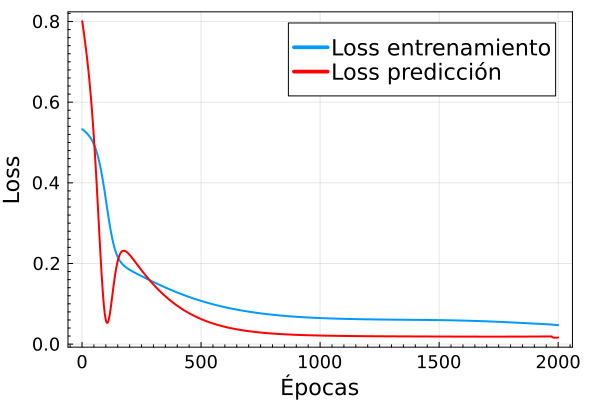

Debido a que la mayoria de las señales en la predicción tienen valores cercanos a 0 debido a que ocurren para valores de $t$ cercanos al decaimiento es que tenemos un error de predicción menor al de entrenamiento, entonces en principio no se puede decir que la red haya aprendido a generalizar correctamente.

Veamos las predicciones de la red neuronal para ciertas señales

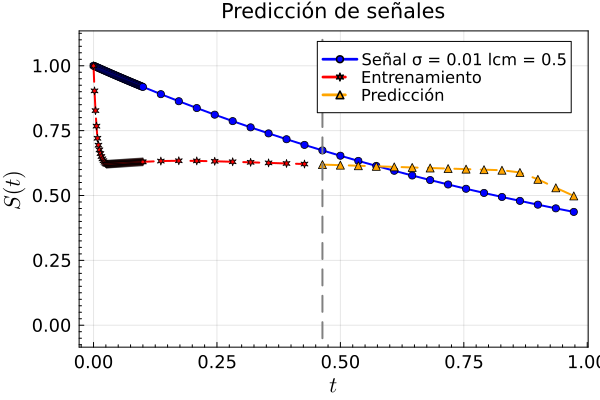

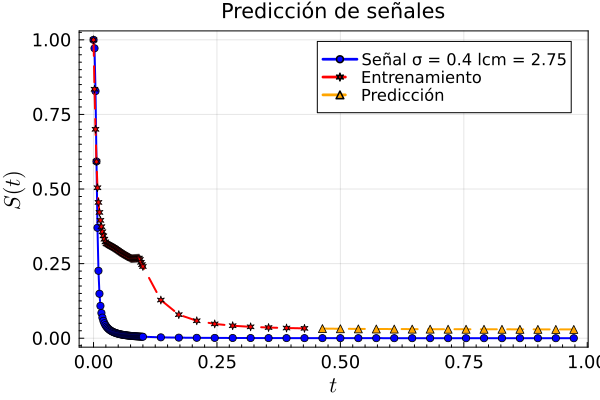

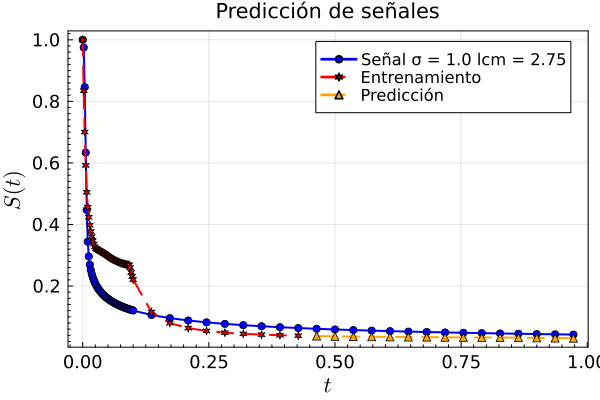

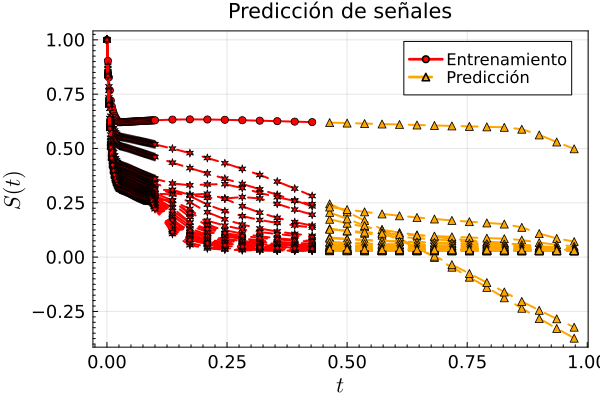

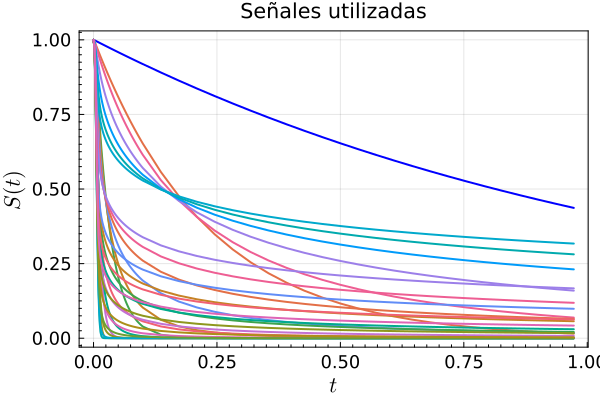

Sigue ocurriendo que las señales se amontonan quizas en la zona donde mas densidad de datos hay. Por lo que la red no aprende a generalizar correctamente.

Traté de sacar tantas señales similares en esos puntos dando el siguiente conjunto de señales menos representativo que el anteriro pero aún así cubriendo el espacio de señales que tenemos en el dataset.

En este caso no se utilizó la penalización en la función de costo.

* En este caso tenemos 30 señales mezclando $\sigma = \{0.01,~0.2,~0.4,~0.6,~0.8,~1\}$ y $l_{cm} = \{0.5,~0.75,~1.0,~1.25,~1.5\}$

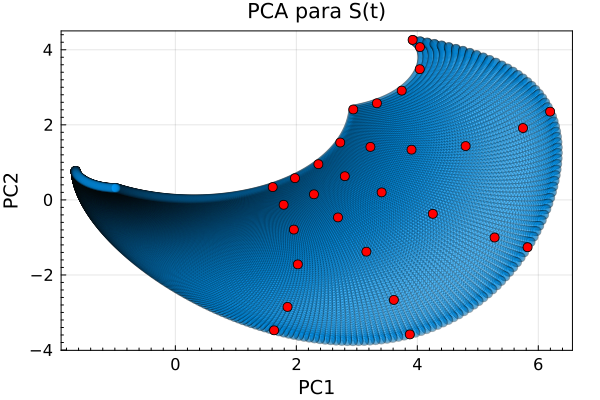

Los resultados de la exploración de las redes entrenadas con este conjunto de señales son los siguientes

$$\begin{aligned}
& \begin{array}{cccccc}
\hline \hline
\textbf{ID} & \textbf{Arquitectura} & \textbf{Activación} & \textbf{Optimizador} & \textbf{Batch Size} & \textbf{Loss Final Entrenamiento} & \textbf{Loss Final Predicción} \\ \hline
1  & 2, 8, 1            & relu                 & AdamW                 & 30                   & 0.18138              & 0.06550               \\ \hline
2  & 2, 8, 1            & relu                 & AdamW                 & 60                   & 0.29828              & 0.91709               \\ \hline
3  & 2, 8, 1            & relu                 & RMSProp               & 30                   & 0.21141              & 0.08631               \\ \hline
4  & 2, 8, 1            & relu                 & RMSProp               & 60                   & 0.32081              & 0.72909               \\ \hline
5  & 2, 8, 1            & tanh                 & AdamW                 & 30                   & 0.16616              & 0.12923               \\ \hline
6  & 2, 8, 1            & tanh                 & AdamW                 & 60                   & 0.20412              & 0.06995               \\ \hline
7  & 2, 8, 1            & tanh                 & RMSProp               & 30                   & 0.13303              & 0.31857               \\ \hline
8  & 2, 8, 1            & tanh                 & RMSProp               & 60                   & 0.23196              & 0.09752               \\ \hline
9  & 2, 8, 1            & swish                & AdamW                 & 30                   & 0.20328              & 0.04683               \\ \hline
10 & 2, 8, 1            & swish                & AdamW                 & 60                   & 0.22994              & 0.13114               \\ \hline
11 & 2, 8, 1            & swish                & RMSProp               & 30                   & 0.27957              & 0.39572               \\ \hline
12 & 2, 8, 1            & swish                & RMSProp               & 60                   & 0.29670              & 0.51079               \\ \hline
13 & 2, 16, 16, 1       & relu                 & AdamW                 & 30                   & 0.12436              & 0.23578               \\ \hline
14 & 2, 16, 16, 1       & relu                 & AdamW                 & 60                   & 0.20449              & 0.06106               \\ \hline
15 & 2, 16, 16, 1       & relu                 & RMSProp               & 30                   & 0.15192              & 0.12456               \\ \hline
16 & 2, 16, 16, 1       & relu                 & RMSProp               & 60                   & 0.14615              & 0.12199               \\ \hline
17 & 2, 16, 16, 1       & tanh                 & AdamW                 & 30                   & 0.10095              & 0.23465               \\ \hline
18 & 2, 16, 16, 1       & tanh                 & AdamW                 & 60                   & 0.12239              & 0.35243               \\ \hline
19 & 2, 16, 16, 1       & tanh                 & RMSProp               & 30                   & 0.10738              & 0.30425               \\ \hline
20 & 2, 16, 16, 1       & tanh                 & RMSProp               & 60                   & 0.10979              & 0.30945               \\ \hline
21 & 2, 16, 16, 1       & swish                & AdamW                 & 30                   & 0.12717              & 0.44012               \\ \hline
22 & 2, 16, 16, 1       & swish                & AdamW                 & 60                   & 0.17742              & 0.08315               \\ \hline
23 & 2, 16, 16, 1       & swish                & RMSProp               & 30                   & 0.09651              & 0.36198               \\ \hline
24 & 2, 16, 16, 1       & swish                & RMSProp               & 60                   & 0.16837              & 0.07821               \\ \hline
25 & 2, 32, 64, 16, 1   & relu                 & AdamW                 & 30                   & 0.06255              & 0.05192               \\ \hline
26 & 2, 32, 64, 16, 1   & relu                 & AdamW                 & 60                   & 0.08133              & 0.08197               \\ \hline
27 & 2, 32, 64, 16, 1   & relu                 & RMSProp               & 30                   & 0.05814              & 0.04315               \\ \hline
28 & 2, 32, 64, 16, 1   & relu                 & RMSProp               & 60                   & 0.09630              & 0.38492               \\ \hline
29 & 2, 32, 64, 16, 1   & tanh                 & AdamW                 & 30                   & 0.06744              & 0.03438               \\ \hline
30 & 2, 32, 64, 16, 1   & tanh                 & AdamW                 & 60                   & 0.07898              & 0.07613               \\ \hline
32 & 2, 32, 64, 16, 1 & tanh & RMSProp & 60 & 0.07112 & 0.03230 \\ \hline
33 & 2, 32, 64, 16, 1 & swish & AdamW & 30 & 0.06724 & 0.11372 \\ \hline
34 & 2, 32, 64, 16, 1 & swish & AdamW & 60 & 0.08945 & 0.30299 \\\hline
35 & 2, 32, 64, 16, 1 & swish & RMSProp & 30 & 0.06251 & 0.08129 \\\hline
36 & 2, 32, 64, 16, 1 & swish & RMSProp & 60 & 0.08936 & 0.22087 \\\hline
37 & 2, 128, 64, 16, 1 & relu & AdamW & 30 & 0.05204 & 0.02930 \\\hline
38 & 2, 128, 64, 16, 1 & relu & AdamW & 60 & 0.05856 & 0.03259 \\\hline
39 & 2, 128, 64, 16, 1 & relu & RMSProp & 30 & 0.04697 & 0.02880 \\\hline
40 & 2, 128, 64, 16, 1 & relu & RMSProp & 60 & 0.05734 & 0.03662 \\\hline
41 & 2, 128, 64, 16, 1 & tanh & AdamW & 30 & 0.06668 & 0.02979 \\\hline
42 & 2, 128, 64, 16, 1 & tanh & AdamW & 60 & 0.08812 & 0.04844 \\\hline
43 & 2, 128, 64, 16, 1 & tanh & RMSProp & 30 & 0.05864 & 0.02979 \\\hline
44 & 2, 128, 64, 16, 1 & tanh & RMSProp & 60 & 0.08439 & 0.02979 \\\hline
45 & 2, 128, 64, 16, 1 & swish & AdamW & 30 & 0.05757 & 0.04805 \\\hline
46 & 2, 128, 64, 16, 1 & swish & AdamW & 60 & 0.07007 & 0.11682 \\\hline
47 & 2, 128, 64, 16, 1 & swish & RMSProp & 30 & 0.04901 & 0.03452 \\\hline
48 & 2, 128, 64, 16, 1 & swish & RMSProp & 60 & 0.05360 & 0.03311 \\\hline
49 & 2, 64, 128, 64, 32, 16, 1 & relu & AdamW & 30 & 0.04022 & 0.02865 \\\hline
50 & 2, 64, 128, 64, 32, 16, 1 & relu & AdamW & 60 & 0.04647 & 0.02873 \\\hline
51 & 2, 64, 128, 64, 32, 16, 1 & relu & RMSProp & 30 & 0.04108 & 0.03032 \\\hline
52 & 2, 64, 128, 64, 32, 16, 1 & relu & RMSProp & 60 & 0.03754 & 0.03280 \\\hline
53 & 2, 64, 128, 64, 32, 16, 1 & tanh & AdamW & 30 & 0.06183 & 0.02966 \\\hline
54 & 2, 64, 128, 64, 32, 16, 1 & tanh & AdamW & 60 & 0.06758 & 0.02967 \\\hline
55 & 2, 64, 128, 64, 32, 16, 1 & tanh & RMSProp & 30 & 0.05917 & 0.02989 \\\hline
56 & 2, 64, 128, 64, 32, 16, 1 & tanh & RMSProp & 60 & 0.06266 & 0.02970 \\\hline
57 & 2, 64, 128, 64, 32, 16, 1 & swish & AdamW & 30 & 0.04732 & 0.03786 \\\hline
58 & 2, 64, 128, 64, 32, 16, 1 & swish & AdamW & 60 & 0.04928 & 0.03862 \\\hline
59 & 2, 64, 128, 64, 32, 16, 1 & swish & RMSProp & 30 & 0.04627 & 0.03786 \\\hline
60 & 2, 64, 128, 64, 32, 16, 1 & swish & RMSProp & 60 & 0.04451 & 0.04630 \\\hline
61 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & relu & AdamW & 30 & 0.03343 & 0.04498 \\\hline
62 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & relu & AdamW & 60 & 0.03981 & 0.02833 \\ \hline
63 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & relu & RMSProp & 30 & 0.03658 & 0.03185 \\ \hline
64 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & relu & RMSProp & 60 & 0.03583 & 0.03020 \\ \hline
65 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & tanh & AdamW & 30 & 0.08163 & 0.02985 \\ \hline
66 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & tanh & AdamW & 60 & 0.10231 & 0.02944 \\ \hline
67 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & tanh & RMSProp & 30 & 0.08671 & 0.02683 \\ \hline
68 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & tanh & RMSProp & 60 & 0.09466 & 0.02790 \\ \hline
69 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & swish & AdamW & 30 & 0.04235 & 0.03622 \\ \hline
70 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & swish & AdamW & 60 & 0.04735 & 0.04101 \\ \hline
71 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & swish & RMSProp & 30 & 0.03905 & 0.30271 \\ \hline
72 & 2, 128, 256, 32, 64, 32, 16, 8, 1 & swish & RMSProp & 60 & 0.03591 & 0.08891 \\
\hline
\end{array}
\end{aligned}$$

De estos es la red 67 la que tiene menor error de predicción, tengamos en cuenta que esta exploración fue durante 1000 épocas únicamente para hacerlo más rápido.
Veamos los resultados con esta red.

* Veamos el loss

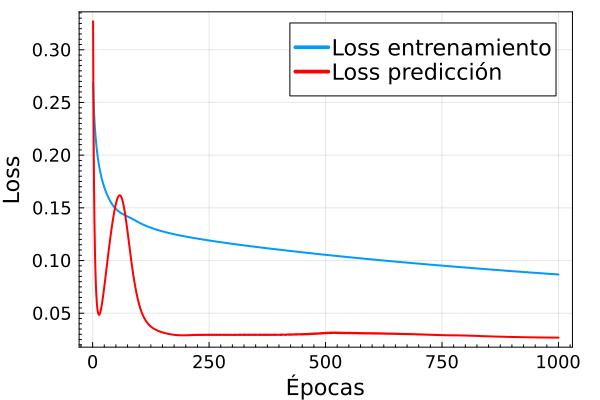

Mismo caso que lo anteriror, sin embargo esta vez hay mucha mas diferencia entre el loss de entrenamiento y el de predicción.

* Veamos las señales utilizadas

 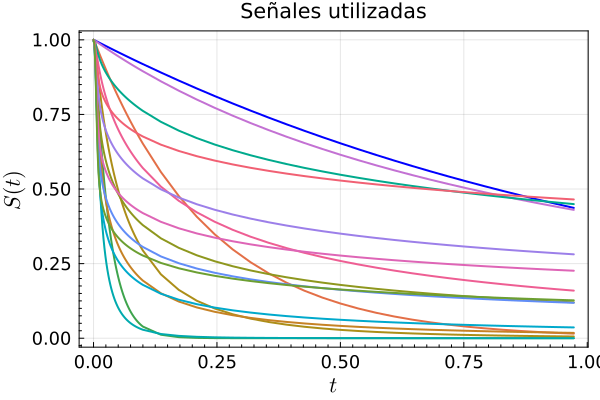

* Veamos las predicciones

 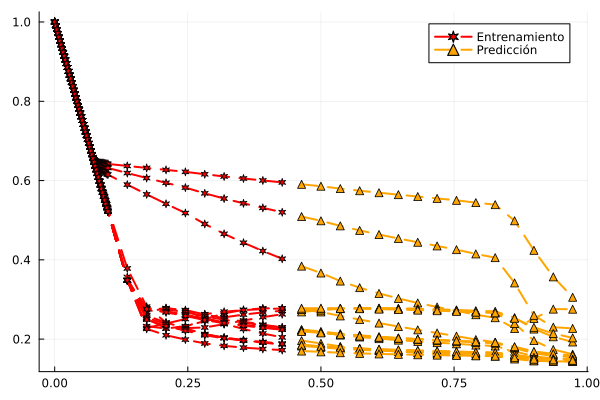

Mismo que antes las señales se amontonan en la zona donde hay mas densidad de datos, por lo que la red no aprende a generalizar correctamente.